# Using Visual Transformers for emotion recognition
Dataset: fer-2013

### Required libraries (working on py3.9)
torch
torchvision
datasets
transformers
matplotlib
pillow
sklearn
opencv-python
imutils

In [1]:
import datasets
from PIL import Image
import io
from IPython import display
from matplotlib.pyplot import imshow
%matplotlib inline


c:\Users\AmirElkess\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading dataset

In [2]:
train, test = datasets.load_dataset("Jeneral/fer-2013", split=["train", "test"])
splits = train.train_test_split(test_size=0.1)
train = splits['train']
val = splits['test']
del splits

Using custom data configuration default
Reusing dataset fer2013 (C:\Users\AmirElkess\.cache\huggingface\datasets\Jeneral___fer2013\default\0.0.0\0fb00ec122d7d9485e58ee9ef0eec3eb193c0d71aadfc61b61d33a46c2d3a45a)
100%|██████████| 2/2 [00:00<00:00, 45.67it/s]


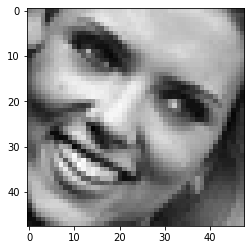

In [3]:
image_data = train[3]["img_bytes"]
image = Image.open(io.BytesIO(image_data))
# image.show()
imshow(image, "gray") # images are 48*48 grayscale

In [4]:
id2label = {id:label for id, label in enumerate(train.features['labels'].names)}
label2id = {label:id for id, label in id2label.items()}

## Preprocessing

In [5]:

from transformers import ViTFeatureExtractor

# if problems happen, make sure to run using python 3.9
from torchvision.transforms import (
    CenterCrop,
    Compose,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from torchvision.transforms import Normalize


In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


In [7]:
normalize = Normalize(
    mean=feature_extractor.image_mean, std=feature_extractor.image_std
)

_train_transforms = Compose(
    [
        RandomResizedCrop(feature_extractor.size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

_val_transforms = Compose(
    [
        Resize(feature_extractor.size),
        CenterCrop(feature_extractor.size),
        ToTensor(),
        normalize,
    ]
)


def train_transforms(examples):
    examples["img_bytes"] = [
        _train_transforms(Image.open(io.BytesIO(image)).convert("RGB")) for image in examples["img_bytes"]
    ]
    return examples


def val_transforms(examples):
    examples["img_bytes"] = [
        _val_transforms(Image.open(io.BytesIO(image)).convert("RGB")) for image in examples["img_bytes"]
    ]
    return examples


In [8]:
train.set_transform(train_transforms)
val.set_transform(val_transforms)
test.set_transform(val_transforms)

## The model

In [9]:
from transformers import ViTForImageClassification
from collections import defaultdict
from transformers import TrainingArguments, Trainer
from datasets import load_metric
import numpy as np
import torch

In [10]:
model = ViTForImageClassification.from_pretrained('./pretrained_1',
                                                  num_labels=7,
                                                  id2label=id2label,
                                                  label2id=label2id)

In [11]:
metric_name = "accuracy"

args = TrainingArguments(
    f"test-fer-2013",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [12]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [13]:
def collate_fn(examples):
    pixel_values = torch.stack([example["img_bytes"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [14]:
trainer = Trainer(
    model,
    args,
    train_dataset=train,
    eval_dataset=val,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [15]:
torch.cuda.is_available()

False

## Predicting on custom image

In [16]:

def process_image_from_array(image):
  success, encoded_image = cv2.imencode('.png', image)
  image = encoded_image.tobytes()

  custom_set = dict()

  f = image #.read()
  _bytes = bytearray(f)

  # image = Image.open(io.BytesIO(_bytes))
  # imshow(image, "gray")

  custom_set["img_bytes"] = _train_transforms(Image.open(io.BytesIO(_bytes)).convert("RGB"))
  custom_set["labels"] = 0

  result = np.argmax(trainer.predict([custom_set], ignore_keys=["labels"]).predictions)
  return id2label[result]

# "angry": 0,
# "disgust": 1,
# "fear": 2,
# "happy": 3,
# "neutral": 4,
# "sad": 5,
# "surprise": 6

# Realtime emotion detection

In [17]:
from imutils.video import WebcamVideoStream
from imutils.video import VideoStream
import matplotlib.pyplot as plt
import time
import imutils
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
# from google.colab.output import eval_js
from base64 import b64decode
# from google.colab import files
import io

In [18]:
print("[INFO] loading model...")
prototxt = './preprocessing/deploy.prototxt'
model = './preprocessing/res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


In [19]:
vs = WebcamVideoStream(src=0).start()
# time.sleep(1)
count = 0
started = False
frame_counter = 0
while True:
# grab the frame from the threaded video stream and resize it
# to have a maximum width of 400 pixels
    frame1 = vs.read()
    frame = imutils.resize(frame1, width=400)
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    for i in range(0, detections.shape[2]):

        # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence threshold
        if confidence > 0.5:
            started = True
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # draw the bounding box of the face along with the associated probability
            # text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX-1, startY-1), (endX+1, endY+1), (0, 0, 255), 1)
            # cv2.putText(frame, text, (startX, y),
            #     cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
       #if confidence >=0.9:
            #cv2.imwrite("frame%d.jpg" % count, cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))
            #count += 1

    if started:
        cropped_frame = frame[startY:endY, startX:endX]
        cropped_frame = imutils.resize(cropped_frame, width=48)
        cropped_frame = cv2.cvtColor(cropped_frame,cv2.COLOR_BGR2GRAY)

        prediction_text = process_image_from_array(cropped_frame)
        
        cv2.putText(frame, prediction_text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.imshow("Frame",frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
cv2.destroyAllWindows()
vs.stop()
vs.stream.release()

NameError: name 'startY' is not defined